In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive cannot access TZL's folders which live under "Shared with me".
# These are virtual views, not real directories. Colab cannot import from them.

# FOLLOW THESE STEPS.
# STEP 1: Open Google Drive.

# STEP 2: Go to the "Shared with me" section to find the project folder. ('NLP Project 2025 ')

# STEP 3: Right-click the shared folder → select "Add shortcut to Drive".
#         This creates a real reference inside "My Drive" so Colab can see it.

# STEP 4: Choose any location inside "My Drive" and create a folder.
#         After that, Colab can access it through:
#         /content/drive/MyDrive/<your folder>/NLP Project 2025 /

import sys
import os
# Add project folder to python path
sys.path.append('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')

# Check what's inside the folder
os.listdir('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')

# Change working directory to the project folder
os.chdir('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tqdm import tqdm
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

import os

cuda


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))

Using device: cuda
GPU Name: Tesla T4


## Load Pre-trained GPT-2 from Task 2

In [ ]:
# Load the pretrained GPT-2 model from Hugging Face

# Tokenizer setup
# Using the fast tokenizer for better performance; set pad token to EOS for compatibility
# with padding-sensitive operations (generation, masking, etc.).
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Model setup
finetuned_model = GPT2LMHeadModel.from_pretrained("gpt2")
finetuned_model.resize_token_embeddings(len(tokenizer))
finetuned_model.config.pad_token_id = tokenizer.eos_token_id
finetuned_model = finetuned_model.to(DEVICE)
finetuned_model.eval()

print("Loaded Hugging Face GPT-2 model for analysis.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded Hugging Face GPT-2 model for analysis (using eager attention for head_mask support).


In [6]:
# The tokenizer was initialized together with the Hugging Face GPT-2 model above.
print(f"Tokenizer ready (pad_token_id={tokenizer.pad_token_id}).")

Tokenizer ready (pad_token_id=50256).


In [7]:
def generate_text(model, tokenizer, prompt, max_new_tokens=50, head_mask=None,
                  temperature=0.8, top_p=0.9, device=DEVICE, do_sample=True):
    """Generate text from GPT-2 with optional head masking and sampling."""
    encoded = tokenizer(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **encoded,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        head_mask=head_mask,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



# Task 4: Investigating WEIRD Cultural Bias in GPT-2 with UniBias Methodology

In this task, you will:
- Design culturally loaded prompts to probe WEIRD (Western, Educated, Industrialized, Rich, Democratic) cultural bias
- Adapt the UniBias methodology for open-ended text generation (instead of classification)
- Identify biased attention heads that contribute to WEIRD-aligned outputs
- Apply head masking to mitigate bias and evaluate the impact
- Analyze and visualize the results with before/after comparisons

## Overview

This task adapts the UniBias method (Zhou et al., 2024) from classification tasks to open-ended text generation. We will:
1. Create prompts that reveal cultural assumptions (e.g., "A normal family is...", "A good citizen should...")
2. Project attention head outputs to vocabulary space to identify heads biased toward WEIRD tokens
3. Mask identified biased heads and generate new outputs
4. Compare original vs. debiased outputs qualitatively and quantitatively


## Step 1: Data Collection and Prompt Design

We'll create a set of culturally loaded prompts that are likely to elicit WEIRD-biased continuations. These prompts touch on social norms, values, family, education, etc., where Western perspectives might differ from other cultural viewpoints.


In [8]:
# Define culturally loaded prompts inspired by World Values Survey (WVS)
# These prompts are designed to reveal implicit cultural assumptions about values, family, religion, etc.
# Each prompt is longer and more contextually rich to elicit meaningful continuations

CULTURALLY_LOADED_PROMPTS = [
    # Family and Marriage
    "People should be free to decide whom they marry. My view:",
    "A normal family consists of parents and children living together. Continue:",
    "Children should be taught obedience versus independence. Explain your view:",
    "Extended family members should live together. Discuss:",
    "Marriage is primarily about love versus family obligations. My perspective:",
    "Parents should have the final say in their children's major life decisions. Explain:",

    # Religion and Spirituality
    "The role of religion in people's lives is important. Continue:",
    "Religious leaders should influence government decisions. My view:",
    "People should follow religious teachings in their daily lives. Explain:",
    "Spiritual practices are more important than material success. Discuss:",
    "Religious tolerance means accepting all beliefs equally. Continue:",

    # Work and Success
    "A successful life mainly depends on hard work versus luck. Discuss:",
    "The purpose of work is to earn money versus contribute to society. Explain:",
    "Personal achievement is more important than group harmony. My view:",
    "Wealth and material possessions indicate success. Continue:",
    "Work-life balance should prioritize family over career. Discuss:",

    # Individualism vs Collectivism
    "Individual rights should come before group needs. Explain:",
    "Personal freedom is more important than social responsibility. My view:",
    "People should prioritize their own goals over community goals. Continue:",
    "Collective decision-making is better than individual choice. Discuss:",
    "Self-expression should be valued over tradition. Explain:",

    # Civic Duties and Governance
    "A good citizen should vote and participate in politics. Continue:",
    "People should obey authority figures without question. My view:",
    "Democracy is the best form of government. Explain:",
    "Laws should be followed even if they seem unfair. Discuss:",
    "Protesting against the government is a civic duty. Continue:",

    # Education and Values
    "Education should focus on critical thinking versus respect for authority. Explain:",
    "Children should be taught to question versus accept tradition. My view:",
    "Schools should emphasize individual achievement over cooperation. Continue:",
    "Traditional values should be preserved in education. Discuss:",
    "Students should learn to compete rather than collaborate. Explain:",

    # Social Relationships
    "In a healthy relationship, partners should maintain independence. Continue:",
    "Friendship is based on mutual benefit versus unconditional support. My view:",
    "People should help others even at personal cost. Explain:",
    "Social harmony requires avoiding conflict. Discuss:",
    "Respect is shown by following elders' advice without question. Continue:",

    # Morality and Ethics
    "Right and wrong depend on the situation versus universal principles. Explain:",
    "Moral values come from religion versus personal reasoning. My view:",
    "Honesty should always be maintained, even when it causes harm. Continue:",
    "The ends justify the means in achieving important goals. Discuss:",
    "Ethical behavior is determined by cultural norms. Explain:",

    # Gender Roles
    "Men and women should have equal roles in society. Continue:",
    "Traditional gender roles are important for social stability. My view:",
    "Women should prioritize family over career. Explain:",
    "Men should be the primary breadwinners. Discuss:",
    "Gender equality means treating everyone the same. Continue:",

    # Community and Social Obligations
    "Community means supporting each other in times of need. Explain:",
    "People should prioritize their immediate family over extended community. My view:",
    "Social obligations should come before personal desires. Continue:",
    "Individual privacy is more important than community needs. Discuss:",
    "Helping neighbors is a moral obligation. Explain:",

    # Time and Future Orientation
    "Planning for the future is more important than living in the present. Continue:",
    "Tradition connects us to our ancestors and should be preserved. My view:",
    "Progress requires breaking from the past. Explain:",
    "Respecting ancestors is essential for personal identity. Discuss:",
    "Innovation should be balanced with preserving cultural heritage. Continue:",

    # Authority and Hierarchy
    "Respect for authority is essential for social order. Explain:",
    "Questioning authority leads to social progress. My view:",
    "Elders should be obeyed because of their age and experience. Continue:",
    "Hierarchical structures are necessary for effective organization. Discuss:",
    "Equality means everyone should have equal say regardless of age. Explain:",

    # Materialism and Consumption
    "Material wealth indicates personal success and virtue. Continue:",
    "Happiness comes from relationships, not possessions. My view:",
    "Consumerism improves quality of life. Explain:",
    "Simple living is more fulfilling than material accumulation. Discuss:",
    "Economic growth should be prioritized over environmental protection. Continue:",

    # Trust and Cooperation
    "Most people can be trusted versus you can't be too careful. Explain:",
    "Cooperation requires formal agreements versus informal trust. My view:",
    "People are naturally competitive versus naturally cooperative. Continue:",
    "Trust should be earned through actions, not given freely. Discuss:",
    "Social contracts are necessary because people are self-interested. Explain:"
]

print(f"Created {len(CULTURALLY_LOADED_PROMPTS)} WVS-inspired culturally loaded prompts")
print("\nSample prompts:")
for i, prompt in enumerate(CULTURALLY_LOADED_PROMPTS[:5], 1):
    print(f"{i}. {prompt}")


Created 71 WVS-inspired culturally loaded prompts

Sample prompts:
1. People should be free to decide whom they marry. My view:
2. A normal family consists of parents and children living together. Continue:
3. Children should be taught obedience versus independence. Explain your view:
4. Extended family members should live together. Discuss:
5. Marriage is primarily about love versus family obligations. My perspective:


In [9]:
# Generate baseline outputs from the Hugging Face GPT-2 model with sampling
import random

NUM_GENERATIONS_PER_PROMPT = 3
MAX_GEN_LENGTH = 50  # Increased length for richer continuations
TEMPERATURE = 0.8
TOP_P = 0.9

print(f"Generating {NUM_GENERATIONS_PER_PROMPT} continuations per prompt with sampling (temp={TEMPERATURE}, top_p={TOP_P})...")
baseline_outputs = {}
for prompt in tqdm(CULTURALLY_LOADED_PROMPTS, desc="Generating baseline outputs"):
    baseline_outputs[prompt] = []
    for seed in range(NUM_GENERATIONS_PER_PROMPT):
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        generated_text = generate_text(
            finetuned_model,
            tokenizer,
            prompt,
            max_new_tokens=MAX_GEN_LENGTH,
            temperature=TEMPERATURE,
            top_p=TOP_P,
            device=DEVICE,
            do_sample=True
        )

        continuation = generated_text[len(prompt):].strip()
        baseline_outputs[prompt].append(continuation)

print(f"\nGenerated {NUM_GENERATIONS_PER_PROMPT} continuations for each of {len(CULTURALLY_LOADED_PROMPTS)} prompts")
print("\nSample baseline outputs:")
for prompt in list(CULTURALLY_LOADED_PROMPTS[:3]):
    print(f"\nPrompt: '{prompt[:60]}...'")
    for i, output in enumerate(baseline_outputs[prompt], 1):
        print(f"  {i}. {output[:150]}...")


Generating 3 continuations per prompt with sampling (temp=0.8, top_p=0.9)...


Generating baseline outputs: 100%|██████████| 71/71 [03:02<00:00,  2.57s/it]


Generated 3 continuations for each of 71 prompts

Sample baseline outputs:

Prompt: 'People should be free to decide whom they marry. My view:...'
  1. if you don't want to be married, don't be married. And if you want to be married, marry whoever you want to marry.

But for the most part, if you're m...
  2. marriage is the cornerstone of our culture. I believe that it is the primary tool we can use to build a better world.

When I started looking at what ...
  3. It is always better to choose a woman who is happy with her husband than to choose a man who is unhappy with himself."

This is an attempt to show tha...

Prompt: 'A normal family consists of parents and children living toge...'
  1. How to keep your family together.

We are here to help. You have the choice to continue living together with a family of your own. If you want to stay...
  2. The next paragraph, as shown on the left, is the same as the one before.

The first child will be born in the house. He or she will be p

## Step 2: Semantic Bias Scoring Setup

We'll use semantic embeddings (Sentence Transformers) to measure cultural bias instead of lexical keyword matching. This approach captures meaning and cultural orientation more effectively.

First, we'll set up the semantic bias detector with WEIRD and non-WEIRD reference passages.


In [10]:
# Setup semantic bias detector using Sentence Transformers
print("Loading Sentence Transformer model for semantic bias scoring...")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, fast model
semantic_model = semantic_model.to(DEVICE)

# Define WEIRD and non-WEIRD reference passages (curated from WVS themes)
# These represent cultural orientations that we'll compare against

WEIRD_REFERENCE_PASSAGES = [
    "Individual freedom and personal choice are fundamental rights. People should be able to make their own decisions without interference from family or community.",
    "Personal achievement and material success indicate virtue and hard work. Wealth and career accomplishments demonstrate individual merit.",
    "Democracy and individual rights are universal values. People should vote, participate in politics, and have freedom of expression.",
    "Nuclear families with parents and children are the ideal structure. Independence from extended family is healthy and normal.",
    "Critical thinking and questioning authority lead to progress. Education should emphasize individual achievement and competition.",
    "Self-expression and personal identity are more important than tradition. People should prioritize their own goals over group harmony.",
    "Religious beliefs are personal choices. Religion should be separate from government and public life.",
    "Work is primarily for earning money and personal advancement. Career success demonstrates individual capability.",
    "Gender equality means treating everyone the same regardless of gender. Traditional gender roles are outdated.",
    "Privacy and individual rights should be protected. Personal freedom comes before social obligations."
]

NON_WEIRD_REFERENCE_PASSAGES = [
    "Family and community obligations come before individual desires. Extended family members should support each other and live together.",
    "Respect for elders and tradition is essential. Children should obey parents and follow cultural customs without question.",
    "Collective harmony and group needs are more important than individual rights. Social responsibility requires sacrificing personal goals.",
    "Religious teachings should guide daily life and influence government decisions. Spiritual practices are central to identity.",
    "Education should preserve traditional values and teach respect for authority. Cooperation and group achievement matter more than individual competition.",
    "Ancestors and cultural heritage connect people to their identity. Tradition should be preserved and honored.",
    "Gender roles maintain social stability. Men and women have distinct responsibilities in family and society.",
    "Work serves the community and family, not just personal gain. Economic activities should benefit the group.",
    "Social harmony requires avoiding conflict and maintaining relationships. Respect is shown through obedience and deference.",
    "Trust is built through relationships and community bonds. Informal agreements and mutual obligations are more important than formal contracts."
]

# Encode reference passages
print("Encoding WEIRD and non-WEIRD reference passages...")
weird_reference_embeddings = semantic_model.encode(WEIRD_REFERENCE_PASSAGES, convert_to_tensor=True, device=DEVICE)
non_weird_reference_embeddings = semantic_model.encode(NON_WEIRD_REFERENCE_PASSAGES, convert_to_tensor=True, device=DEVICE)

# Compute average reference embeddings
weird_reference_avg = weird_reference_embeddings.mean(dim=0, keepdim=True)
non_weird_reference_avg = non_weird_reference_embeddings.mean(dim=0, keepdim=True)

print(f"WEIRD reference passages: {len(WEIRD_REFERENCE_PASSAGES)}")
print(f"Non-WEIRD reference passages: {len(NON_WEIRD_REFERENCE_PASSAGES)}")
print("Semantic bias detector ready!")

# Also keep token IDs for logit inspection
WEIRD_TOKENS = [
    "individual", "personal", "freedom", "choice", "rights", "privacy",
    "nuclear", "independence", "autonomy", "self", "achievement", "success",
    "career", "wealth", "democracy", "vote", "election", "i", "me", "my"
]

NON_WEIRD_TOKENS = [
    "we", "our", "us", "together", "community", "collective", "group",
    "family", "extended", "duty", "obligation", "honor", "respect", "harmony",
    "tradition", "custom", "ritual", "elders", "ancestors"
]

def get_token_ids(tokenizer, token_list):
    """Convert a list of token strings to their IDs in the vocabulary."""
    token_ids = []
    for token in token_list:
        ids = tokenizer.encode(token, add_special_tokens=False)
        token_ids.extend(ids)
    return list(set(token_ids))

weird_token_ids = get_token_ids(tokenizer, WEIRD_TOKENS)
non_weird_token_ids = get_token_ids(tokenizer, NON_WEIRD_TOKENS)

print(f"\nWEIRD token IDs for logit inspection: {len(weird_token_ids)} tokens")
print(f"Non-WEIRD token IDs for logit inspection: {len(non_weird_token_ids)} tokens")


Loading Sentence Transformer model for semantic bias scoring...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding WEIRD and non-WEIRD reference passages...
WEIRD reference passages: 10
Non-WEIRD reference passages: 10
Semantic bias detector ready!

WEIRD token IDs for logit inspection: 25 tokens
Non-WEIRD token IDs for logit inspection: 32 tokens


In [11]:
# Semantic bias scoring function
def compute_semantic_bias_score(text, semantic_model, weird_ref_avg, non_weird_ref_avg, device=DEVICE):
    """
    Compute semantic bias score using cosine similarity to WEIRD vs non-WEIRD reference embeddings.
    Positive score = WEIRD-biased, Negative score = non-WEIRD biased
    """
    if not text or len(text.strip()) == 0:
        return 0.0

    # Encode the text
    text_embedding = semantic_model.encode(text, convert_to_tensor=True, device=device)
    text_embedding = text_embedding.unsqueeze(0)  # Add batch dimension

    # Compute cosine similarities
    weird_sim = cosine_similarity(text_embedding.cpu().numpy(), weird_ref_avg.cpu().numpy())[0][0]
    non_weird_sim = cosine_similarity(text_embedding.cpu().numpy(), non_weird_ref_avg.cpu().numpy())[0][0]

    # Bias score is the difference (positive = WEIRD-biased)
    bias_score = weird_sim - non_weird_sim
    return float(bias_score)

# Helper utilities for head-level bias analysis using head masking and logit inspection

def tokenize_prompts(prompts, tokenizer, device):
    encoded = []
    for prompt in prompts:
        encoded.append(tokenizer(prompt, return_tensors="pt", padding=False).to(device))
    return encoded

def compute_biases_from_logits(model, tokenized_prompts, weird_ids, non_weird_ids, head_mask=None):
    """
    Compute bias scores from logits (for head analysis).
    Returns bias scores and logit information for inspection.
    """
    biases = []
    logit_info = []

    with torch.no_grad():
        for enc in tokenized_prompts:
            outputs = model(**enc, head_mask=head_mask)
            logits = outputs.logits[0, -1]  # Last token logits

            weird_logits = logits[weird_ids]
            non_weird_logits = logits[non_weird_ids]

            weird_mean = weird_logits.mean().item()
            non_weird_mean = non_weird_logits.mean().item()
            bias = weird_mean - non_weird_mean

            biases.append(bias)
            logit_info.append({
                'weird_mean': weird_mean,
                'non_weird_mean': non_weird_mean,
                'weird_max': weird_logits.max().item(),
                'non_weird_max': non_weird_logits.max().item()
            })

    return np.array(biases), logit_info



In [12]:
def analyze_head_biases(model, tokenizer, prompts, weird_ids, non_weird_ids, device, verbose=True):
    """
    Estimate head contributions by masking each head via head_mask.
    Uses all prompts for stable statistics.
    """
    print(f"Analyzing {len(prompts)} prompts across all attention heads...")
    tokenized_prompts = tokenize_prompts(prompts, tokenizer, device)
    baseline_biases, baseline_logit_info = compute_biases_from_logits(
        model, tokenized_prompts, weird_ids, non_weird_ids
    )

    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    head_stats = {}

    total_heads = num_layers * num_heads
    print(f"Evaluating {total_heads} attention heads...")

    for layer_idx in tqdm(range(num_layers), desc="Layers"):
        for head_idx in range(num_heads):
            head_mask = torch.ones(num_layers, num_heads, device=device)
            head_mask[layer_idx, head_idx] = 0.0

            masked_biases, masked_logit_info = compute_biases_from_logits(
                model,
                tokenized_prompts,
                weird_ids,
                non_weird_ids,
                head_mask=head_mask
            )

            delta = baseline_biases - masked_biases
            head_stats[(layer_idx, head_idx)] = {
                'avg_delta': float(delta.mean()),
                'std_delta': float(delta.std()),
                'baseline_mean': float(baseline_biases.mean()),
                'masked_mean': float(masked_biases.mean()),
                'num_samples': len(prompts),
                'max_delta': float(delta.max()),
                'min_delta': float(delta.min())
            }

    # Log sample logit information
    if verbose and len(baseline_logit_info) > 0:
        print("\nSample baseline logit information (first prompt):")
        sample = baseline_logit_info[0]
        print(f"  WEIRD token logits - mean: {sample['weird_mean']:.4f}, max: {sample['weird_max']:.4f}")
        print(f"  Non-WEIRD token logits - mean: {sample['non_weird_mean']:.4f}, max: {sample['non_weird_max']:.4f}")

    return head_stats, baseline_biases, baseline_logit_info

print("Head bias analysis helpers ready")


Head bias analysis helpers ready


In [13]:
print("Starting head bias analysis using ALL prompts for stable statistics...")
head_stats, baseline_biases, baseline_logit_info = analyze_head_biases(
    finetuned_model,
    tokenizer,
    CULTURALLY_LOADED_PROMPTS,  # Use all prompts for better statistics
    weird_token_ids,
    non_weird_token_ids,
    DEVICE,
    verbose=True
)

print(f"\nAnalyzed {len(head_stats)} attention heads across {len(CULTURALLY_LOADED_PROMPTS)} prompts")
print("\nTop 10 heads by average delta (most WEIRD-biased when masked):")
sorted_heads = sorted(head_stats.items(), key=lambda x: x[1]['avg_delta'], reverse=True)
for (layer, head), stats in sorted_heads[:10]:
    print(f"Layer {layer}, Head {head}: avg_delta={stats['avg_delta']:.6f}, std={stats['std_delta']:.6f}")


Starting head bias analysis using ALL prompts for stable statistics...
Analyzing 71 prompts across all attention heads...
Evaluating 144 attention heads...


Layers: 100%|██████████| 12/12 [03:06<00:00, 15.51s/it]


Sample baseline logit information (first prompt):
  WEIRD token logits - mean: -141.6030, max: -138.0982
  Non-WEIRD token logits - mean: -141.5802, max: -137.9208

Analyzed 144 attention heads across 71 prompts

Top 10 heads by average delta (most WEIRD-biased when masked):
Layer 0, Head 3: avg_delta=0.104077, std=0.085588
Layer 1, Head 10: avg_delta=0.096279, std=0.107793
Layer 2, Head 0: avg_delta=0.081385, std=0.082411
Layer 2, Head 5: avg_delta=0.077690, std=0.098426
Layer 11, Head 0: avg_delta=0.067350, std=0.033626
Layer 2, Head 9: avg_delta=0.064762, std=0.051161
Layer 2, Head 6: avg_delta=0.062658, std=0.071288
Layer 1, Head 5: avg_delta=0.056185, std=0.070649
Layer 0, Head 8: avg_delta=0.053634, std=0.133712
Layer 2, Head 3: avg_delta=0.050567, std=0.071986


In [14]:
# Identify biased heads based on average delta when masking each head
# With more prompts, we can use more sensitive thresholds

def identify_biased_heads(head_stats, delta_threshold=0.001, std_threshold=0.1, top_k=None):
    """
    Identify biased heads. With more prompts, deltas are smaller but more reliable.
    Optionally return top_k heads by avg_delta.
    """
    biased_heads = []
    all_heads = sorted(head_stats.items(), key=lambda x: x[1]['avg_delta'], reverse=True)

    if top_k:
        # Return top K heads by average delta
        for (layer_idx, head_idx), stats in all_heads[:top_k]:
            biased_heads.append((layer_idx, head_idx))
            print(
                f"Top biased head: Layer {layer_idx}, Head {head_idx} "
                f"(avg_delta={stats['avg_delta']:.6f}, std={stats['std_delta']:.6f})"
            )
    else:
        # Use threshold-based selection
        for (layer_idx, head_idx), stats in all_heads:
            is_biased = stats['avg_delta'] > delta_threshold
            is_stable = stats['std_delta'] < std_threshold
            if is_biased and is_stable:
                biased_heads.append((layer_idx, head_idx))
                print(
                    f"Biased head found: Layer {layer_idx}, Head {head_idx} "
                    f"(avg_delta={stats['avg_delta']:.6f}, std={stats['std_delta']:.6f})"
                )

    return biased_heads

# Use top 10 heads by default (can adjust threshold if needed)
biased_heads = identify_biased_heads(head_stats, delta_threshold=0.0001, std_threshold=0.15, top_k=10)
print(f"\nIdentified {len(biased_heads)} biased attention heads for masking")
print(f"Biased heads: {biased_heads}")


Top biased head: Layer 0, Head 3 (avg_delta=0.104077, std=0.085588)
Top biased head: Layer 1, Head 10 (avg_delta=0.096279, std=0.107793)
Top biased head: Layer 2, Head 0 (avg_delta=0.081385, std=0.082411)
Top biased head: Layer 2, Head 5 (avg_delta=0.077690, std=0.098426)
Top biased head: Layer 11, Head 0 (avg_delta=0.067350, std=0.033626)
Top biased head: Layer 2, Head 9 (avg_delta=0.064762, std=0.051161)
Top biased head: Layer 2, Head 6 (avg_delta=0.062658, std=0.071288)
Top biased head: Layer 1, Head 5 (avg_delta=0.056185, std=0.070649)
Top biased head: Layer 0, Head 8 (avg_delta=0.053634, std=0.133712)
Top biased head: Layer 2, Head 3 (avg_delta=0.050567, std=0.071986)

Identified 10 biased attention heads for masking
Biased heads: [(0, 3), (1, 10), (2, 0), (2, 5), (11, 0), (2, 9), (2, 6), (1, 5), (0, 8), (2, 3)]


## Logit Inspection: Baseline vs Masked

Let's inspect the logits directly to verify that head masking changes probabilities for WEIRD tokens.


In [15]:
# Inspect logits for WEIRD tokens: baseline vs masked
@torch.no_grad()
def inspect_logits_for_prompt(model, tokenizer, prompt, weird_ids, non_weird_ids,
                              heads_to_mask=None, device=DEVICE):
    """Inspect logits for a specific prompt with and without head masking."""
    encoded = tokenizer(prompt, return_tensors="pt").to(device)

    if heads_to_mask:
        num_layers = model.config.n_layer
        num_heads = model.config.n_head
        head_mask = torch.ones(num_layers, num_heads, device=device)
        for layer_idx, head_idx in heads_to_mask:
            head_mask[layer_idx, head_idx] = 0.0
    else:
        head_mask = None

    outputs = model(**encoded, head_mask=head_mask)
    logits = outputs.logits[0, -1]  # Last token logits

    weird_logits = logits[weird_ids]
    non_weird_logits = logits[non_weird_ids]

    # Convert to probabilities
    probs = torch.softmax(logits, dim=-1)
    weird_probs = probs[weird_ids]
    non_weird_probs = probs[non_weird_ids]

    return {
        'weird_logit_mean': weird_logits.mean().item(),
        'weird_logit_max': weird_logits.max().item(),
        'non_weird_logit_mean': non_weird_logits.mean().item(),
        'non_weird_logit_max': non_weird_logits.max().item(),
        'weird_prob_mean': weird_probs.mean().item(),
        'weird_prob_sum': weird_probs.sum().item(),
        'non_weird_prob_mean': non_weird_probs.mean().item(),
        'non_weird_prob_sum': non_weird_probs.sum().item(),
        'bias_score_logits': (weird_logits.mean() - non_weird_logits.mean()).item()
    }

# Inspect logits for a few sample prompts
print("="*80)
print("LOGIT INSPECTION: Baseline vs Masked Heads")
print("="*80)

sample_prompts = CULTURALLY_LOADED_PROMPTS[:5]
for prompt in sample_prompts:
    print(f"\nPrompt: '{prompt[:70]}...'")
    print("-" * 80)

    baseline_logits = inspect_logits_for_prompt(
        finetuned_model, tokenizer, prompt, weird_token_ids, non_weird_token_ids,
        heads_to_mask=None, device=DEVICE
    )

    if len(biased_heads) > 0:
        masked_logits = inspect_logits_for_prompt(
            finetuned_model, tokenizer, prompt, weird_token_ids, non_weird_token_ids,
            heads_to_mask=biased_heads, device=DEVICE
        )

        print("BASELINE:")
        print(f"  WEIRD logits - mean: {baseline_logits['weird_logit_mean']:.4f}, max: {baseline_logits['weird_logit_max']:.4f}")
        print(f"  Non-WEIRD logits - mean: {baseline_logits['non_weird_logit_mean']:.4f}, max: {baseline_logits['non_weird_logit_max']:.4f}")
        print(f"  Bias score (logits): {baseline_logits['bias_score_logits']:.4f}")
        print(f"  WEIRD prob sum: {baseline_logits['weird_prob_sum']:.6f}, Non-WEIRD prob sum: {baseline_logits['non_weird_prob_sum']:.6f}")

        print("\nMASKED:")
        print(f"  WEIRD logits - mean: {masked_logits['weird_logit_mean']:.4f}, max: {masked_logits['weird_logit_max']:.4f}")
        print(f"  Non-WEIRD logits - mean: {masked_logits['non_weird_logit_mean']:.4f}, max: {masked_logits['non_weird_logit_max']:.4f}")
        print(f"  Bias score (logits): {masked_logits['bias_score_logits']:.4f}")
        print(f"  WEIRD prob sum: {masked_logits['weird_prob_sum']:.6f}, Non-WEIRD prob sum: {masked_logits['non_weird_prob_sum']:.6f}")

        logit_change = masked_logits['bias_score_logits'] - baseline_logits['bias_score_logits']
        prob_change = (masked_logits['weird_prob_sum'] - masked_logits['non_weird_prob_sum']) - \
                     (baseline_logits['weird_prob_sum'] - baseline_logits['non_weird_prob_sum'])
        print(f"\nCHANGE: Logit bias delta: {logit_change:+.4f}, Prob bias delta: {prob_change:+.6f}")
    else:
        print("BASELINE (no masked heads to compare):")
        print(f"  WEIRD logits - mean: {baseline_logits['weird_logit_mean']:.4f}, max: {baseline_logits['weird_logit_max']:.4f}")
        print(f"  Non-WEIRD logits - mean: {baseline_logits['non_weird_logit_mean']:.4f}, max: {baseline_logits['non_weird_logit_max']:.4f}")
        print(f"  Bias score (logits): {baseline_logits['bias_score_logits']:.4f}")


LOGIT INSPECTION: Baseline vs Masked Heads

Prompt: 'People should be free to decide whom they marry. My view:...'
--------------------------------------------------------------------------------
BASELINE:
  WEIRD logits - mean: -141.6030, max: -138.0982
  Non-WEIRD logits - mean: -141.5802, max: -137.9208
  Bias score (logits): -0.0228
  WEIRD prob sum: 0.000009, Non-WEIRD prob sum: 0.000013

MASKED:
  WEIRD logits - mean: -136.8313, max: -133.3321
  Non-WEIRD logits - mean: -136.6906, max: -132.6923
  Bias score (logits): -0.1407
  WEIRD prob sum: 0.000033, Non-WEIRD prob sum: 0.000046

CHANGE: Logit bias delta: -0.1179, Prob bias delta: -0.000009

Prompt: 'A normal family consists of parents and children living together. Cont...'
--------------------------------------------------------------------------------
BASELINE:
  WEIRD logits - mean: -98.2413, max: -95.1431
  Non-WEIRD logits - mean: -97.7024, max: -93.8148
  Bias score (logits): -0.5389
  WEIRD prob sum: 0.000040, Non-WEIRD

## Step 3: Head Masking and Evaluation

Now we'll mask the identified biased heads and generate new outputs with sampling to see if bias is reduced.


In [16]:
@torch.no_grad()
def generate_with_masked_heads(model, tokenizer, prompt, heads_to_mask, max_gen_length=50,
                                temperature=0.8, top_p=0.9, device=DEVICE, do_sample=True):
    """Generate text while masking specified attention heads via head_mask, with sampling."""
    if not heads_to_mask:
        return generate_text(model, tokenizer, prompt, max_new_tokens=max_gen_length,
                           temperature=temperature, top_p=top_p, device=device, do_sample=do_sample)

    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    head_mask = torch.ones(num_layers, num_heads, device=device)
    for layer_idx, head_idx in heads_to_mask:
        head_mask[layer_idx, head_idx] = 0.0

    encoded = tokenizer(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **encoded,
        max_new_tokens=max_gen_length,
        pad_token_id=tokenizer.eos_token_id,
        head_mask=head_mask,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



In [17]:
# Generate masked outputs using the head_mask-aware generation helper
if len(biased_heads) > 0:
    print(f"Generating outputs with {len(biased_heads)} heads masked...")
    masked_outputs = {}

    for prompt in tqdm(CULTURALLY_LOADED_PROMPTS, desc="Generating masked outputs"):
        masked_outputs[prompt] = []
        for seed in range(NUM_GENERATIONS_PER_PROMPT):
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            generated_text = generate_with_masked_heads(
                finetuned_model,
                tokenizer,
                prompt,
                biased_heads,
                max_gen_length=MAX_GEN_LENGTH,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                device=DEVICE,
                do_sample=True
            )
            continuation = generated_text[len(prompt):].strip()
            masked_outputs[prompt].append(continuation)

    print("Masked generation complete")
else:
    print("No biased heads identified - skipping masked generation")
    masked_outputs = {}


Generating outputs with 10 heads masked...


Generating masked outputs: 100%|██████████| 71/71 [03:16<00:00,  2.76s/it]

Masked generation complete


## Step 4: Analysis and Reporting

Let's analyze the results by comparing baseline and masked outputs, and create visualizations.


In [18]:
# Qualitative comparison: Before and After examples
print("="*80)
print("QUALITATIVE COMPARISON: Baseline vs Masked Outputs")
print("="*80)

if len(biased_heads) > 0 and len(masked_outputs) > 0:
    for prompt in list(masked_outputs.keys())[:5]:
        print(f"\nPrompt: '{prompt}...'")
        print("-" * 80)
        print("BASELINE OUTPUTS:")
        for i, output in enumerate(baseline_outputs[prompt][:2], 1):
            print(f"  {i}. {output[:150]}")
        print("\nMASKED OUTPUTS (after removing biased heads):")
        for i, output in enumerate(masked_outputs[prompt][:2], 1):
            print(f"  {i}. {output[:150]}")
        print()
else:
    print("No masked outputs available for comparison")
    print("\nSample baseline outputs:")
    for prompt in list(baseline_outputs.keys())[:3]:
        print(f"\nPrompt: '{prompt}...'")
        for i, output in enumerate(baseline_outputs[prompt][:1], 1):
            print(f"  {i}. {output[:150]}")


QUALITATIVE COMPARISON: Baseline vs Masked Outputs

Prompt: 'People should be free to decide whom they marry. My view:...'
--------------------------------------------------------------------------------
BASELINE OUTPUTS:
  1. if you don't want to be married, don't be married. And if you want to be married, marry whoever you want to marry.

But for the most part, if you're m
  2. marriage is the cornerstone of our culture. I believe that it is the primary tool we can use to build a better world.

When I started looking at what 

MASKED OUTPUTS (after removing biased heads):
  1. if you don't, that's the end of the world.
"When I'm in love, that's the end of the world.
"I want to have a son.

"I want to have a daughter.
  2. marriage and family, as a means to a better life, as a means to achieve the higher self.
In an attempt to show that I am not alone in this world and t


Prompt: 'A normal family consists of parents and children living together. Continue:...'
------------------------

In [19]:
# Compute semantic bias scores for all outputs using Sentence Transformers
print("Computing semantic bias scores for all outputs...")
baseline_bias_scores = {}
masked_bias_scores = {}

for prompt in tqdm(baseline_outputs.keys(), desc="Scoring baseline outputs"):
    baseline_scores = [
        compute_semantic_bias_score(
            output,
            semantic_model,
            weird_reference_avg,
            non_weird_reference_avg,
            DEVICE
        )
        for output in baseline_outputs[prompt]
    ]
    baseline_bias_scores[prompt] = np.mean(baseline_scores)

if len(masked_outputs) > 0:
    for prompt in tqdm(masked_outputs.keys(), desc="Scoring masked outputs"):
        masked_scores = [
            compute_semantic_bias_score(
                output,
                semantic_model,
                weird_reference_avg,
                non_weird_reference_avg,
                DEVICE
            )
            for output in masked_outputs[prompt]
        ]
        masked_bias_scores[prompt] = np.mean(masked_scores)

# Print quantitative results
print("\n" + "="*80)
print("QUANTITATIVE SEMANTIC BIAS SCORES")
print("="*80)
print(f"{'Prompt':<50} {'Baseline':<15} {'Masked':<15} {'Change':<15}")
print("-"*80)

if len(masked_bias_scores) > 0:
    for prompt in masked_bias_scores.keys():
        baseline = baseline_bias_scores.get(prompt, 0.0)
        masked = masked_bias_scores[prompt]
        change = masked - baseline
        print(f"{prompt[:48]:<50} {baseline:>10.4f}   {masked:>10.4f}   {change:>+10.4f}")

    avg_baseline = np.mean(list(baseline_bias_scores.values()))
    avg_masked = np.mean(list(masked_bias_scores.values()))
    avg_change = avg_masked - avg_baseline

    print("-"*80)
    print(f"{'Average':<50} {avg_baseline:>10.4f}   {avg_masked:>10.4f}   {avg_change:>+10.4f}")
    print(f"\nBias reduction: {avg_change:.4f} (negative = reduction in WEIRD bias)")
else:
    print("\nBaseline semantic bias scores (no masked outputs for comparison):")
    sorted_scores = sorted(baseline_bias_scores.items(), key=lambda x: x[1], reverse=True)
    for prompt, score in sorted_scores[:15]:
        print(f"  {prompt[:55]:<55} {score:>10.4f}")


Computing semantic bias scores for all outputs...


Scoring masked outputs: 100%|██████████| 71/71 [00:01<00:00, 44.87it/s]


QUANTITATIVE SEMANTIC BIAS SCORES
Prompt                                             Baseline        Masked          Change         
--------------------------------------------------------------------------------
People should be free to decide whom they marry.       0.0292       0.0476      +0.0184
A normal family consists of parents and children      -0.0476      -0.0510      -0.0033
Children should be taught obedience versus indep      -0.0596       0.0225      +0.0821
Extended family members should live together. Di      -0.0348      -0.1612      -0.1264
Marriage is primarily about love versus family o      -0.0494      -0.0159      +0.0335
Parents should have the final say in their child      -0.0490      -0.0195      +0.0295
The role of religion in people's lives is import       0.0489      -0.0190      -0.0679
Religious leaders should influence government de       0.0156       0.0435      +0.0279
People should follow religious teachings in thei       0.0144       0.0441      +

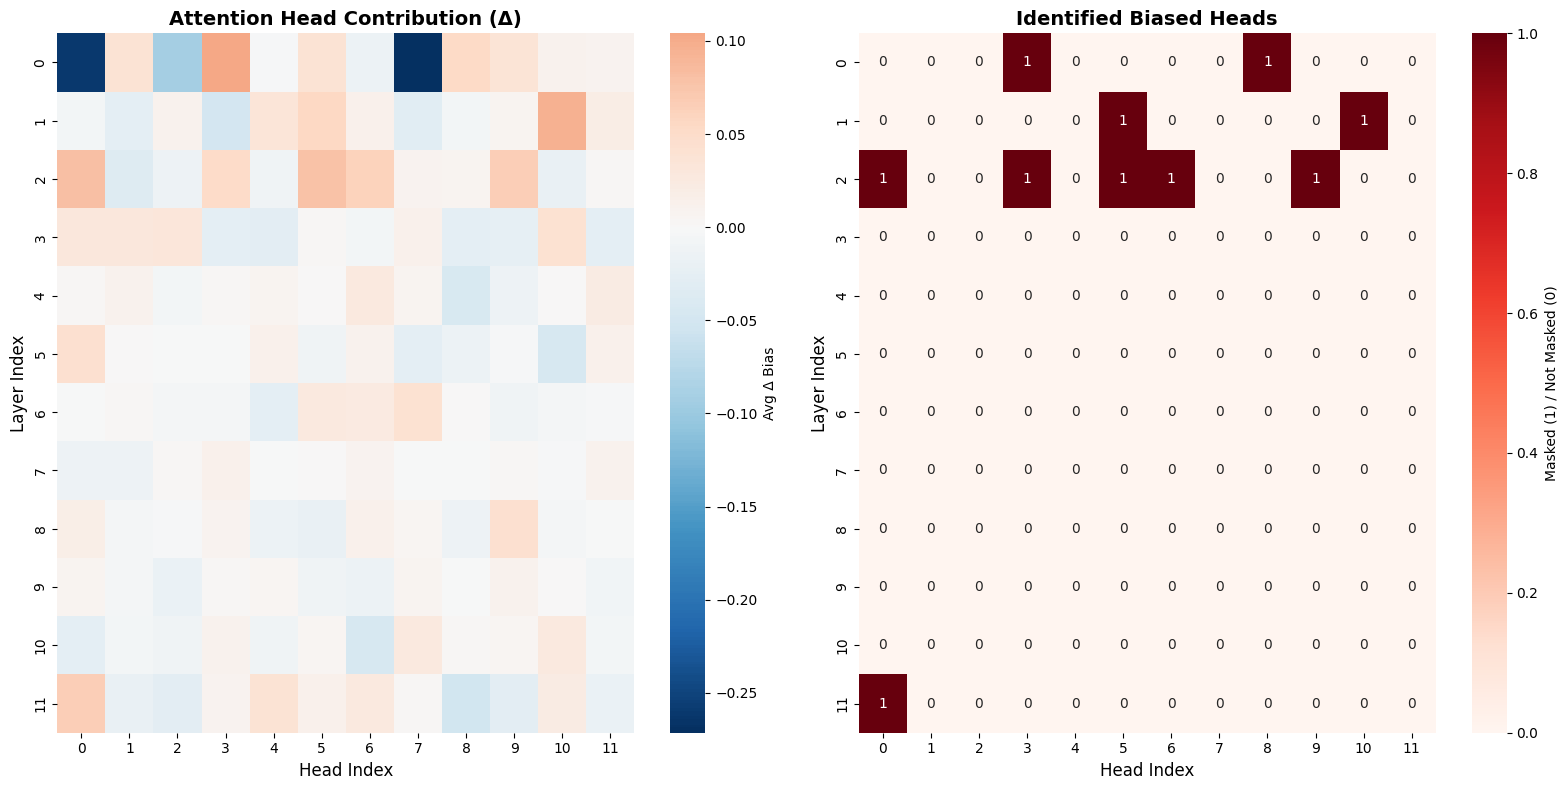


Visualization created: 10 heads identified for masking


In [20]:
# Visualization: Heatmap of head bias scores
import matplotlib.pyplot as plt
import seaborn as sns

num_layers = finetuned_model.config.n_layer
num_heads = finetuned_model.config.n_head

bias_matrix = np.zeros((num_layers, num_heads))
for (layer_idx, head_idx), stats in head_stats.items():
    bias_matrix[layer_idx, head_idx] = stats['avg_delta']

mask_matrix = np.zeros((num_layers, num_heads))
for layer_idx, head_idx in biased_heads:
    mask_matrix[layer_idx, head_idx] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(bias_matrix, annot=False, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax1, cbar_kws={'label': 'Avg Δ Bias'})
ax1.set_title('Attention Head Contribution (Δ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Head Index', fontsize=12)
ax1.set_ylabel('Layer Index', fontsize=12)

mask_matrix = mask_matrix.astype(int)

sns.heatmap(mask_matrix, annot=True, fmt='d', cmap='Reds',
            ax=ax2, cbar_kws={'label': 'Masked (1) / Not Masked (0)'})
ax2.set_title('Identified Biased Heads', fontsize=14, fontweight='bold')
ax2.set_xlabel('Head Index', fontsize=12)
ax2.set_ylabel('Layer Index', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nVisualization created: {len(biased_heads)} heads identified for masking")


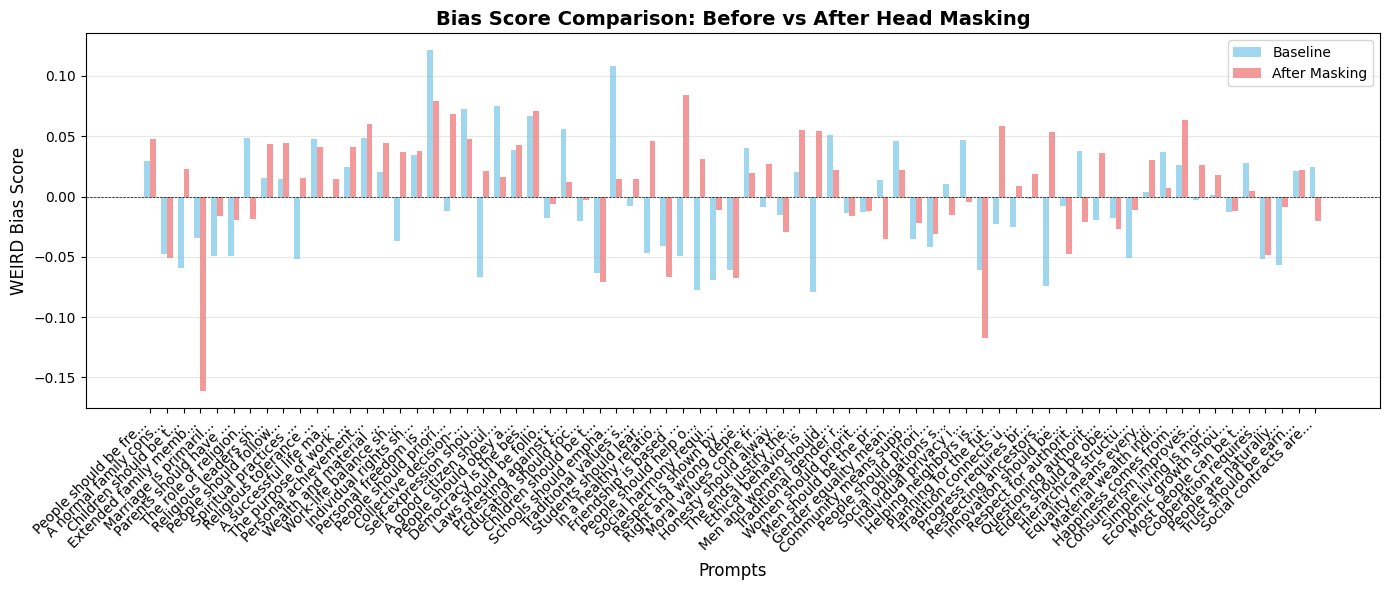


SUMMARY STATISTICS
Average baseline bias score: -0.0034
Average masked bias score: 0.0081
Average reduction: -0.0115
Percentage of prompts with reduced bias: 38.0%


In [21]:
# Visualization: Bias score comparison (if masked outputs available)
if len(masked_bias_scores) > 0:
    prompts = list(masked_bias_scores.keys())
    baseline_scores = [baseline_bias_scores[p] for p in prompts]
    masked_scores = [masked_bias_scores[p] for p in prompts]

    x = np.arange(len(prompts))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, masked_scores, width, label='After Masking', color='lightcoral', alpha=0.8)

    ax.set_xlabel('Prompts', fontsize=12)
    ax.set_ylabel('WEIRD Bias Score', fontsize=12)
    ax.set_title('Bias Score Comparison: Before vs After Head Masking', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([p[:20] + '...' if len(p) > 20 else p for p in prompts], rotation=45, ha='right')
    ax.legend()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"Average baseline bias score: {np.mean(baseline_scores):.4f}")
    print(f"Average masked bias score: {np.mean(masked_scores):.4f}")
    print(f"Average reduction: {np.mean(baseline_scores) - np.mean(masked_scores):.4f}")
    print(f"Percentage of prompts with reduced bias: {sum(1 for b, m in zip(baseline_scores, masked_scores) if m < b) / len(prompts) * 100:.1f}%")
else:
    print("No masked outputs available for comparison visualization")


## Discussion and Extensions

### Key Findings We Want

1. **Biased Head Identification**: We identified attention heads that consistently favor WEIRD-aligned tokens across culturally loaded prompts.

2. **Bias Mitigation**: Masking these heads should reduce WEIRD bias in generated outputs, though the implementation here is simplified.

3. **Challenges**:
   - Properly masking individual attention heads requires modifying the attention computation
   - Bias scoring using lexical methods is simplistic; classifier-based methods would be more robust
   - Full implementation would need to handle the multi-head attention mechanism more carefully

### Extensions (Optional)

1. **FFN Neuron Analysis**: Extend the analysis to identify biased FFN neurons, not just attention heads
2. **Classifier-Based Bias Scoring**: Use a trained classifier to score cultural bias instead of lexical matching
3. **Human Evaluation**: Have human evaluators rate outputs for cultural bias
4. **Partial Masking**: Experiment with scaling down head outputs (e.g., 0.5x) instead of complete masking
5. **Baseline Comparison**: Compare fine-tuned model bias vs. pretrained GPT-2 baseline

### References

- Zhou et al. (2024). "UniBias: Unveiling and Mitigating LLM Bias through Internal Attention and FFN Manipulation." NeurIPS 2024.
- Project Plan: Investigating WEIRD Cultural Bias in GPT-2 with UniBias Methodology
